In [1]:
import pandas as pd 
import numpy as np
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.tree import export_graphviz
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer
import gensim
from gensim import corpora, models, similarities, downloader
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases
from gensim.test.utils import datapath
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from io import StringIO
from html.parser import HTMLParser
from imblearn.over_sampling import SMOTE
import pyLDAvis.gensim
import re
from src.helper import *
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [2]:
df = pd.read_json('data/data.json')

In [3]:
df.acct_type.unique()

array(['fraudster_event', 'premium', 'spammer_warn', 'fraudster',
       'spammer_limited', 'spammer_noinvite', 'locked', 'tos_lock',
       'tos_warn', 'fraudster_att', 'spammer_web', 'spammer'],
      dtype=object)

In [4]:
df.shape

(14337, 44)

In [5]:
df.head()

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
0,fraudster_event,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,...,"[{'event_id': 527017, 'cost': 25.0, 'availabil...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL
1,premium,1296720000,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,...,"[{'event_id': 786878, 'cost': 35.0, 'availabil...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC
2,premium,1296172800,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,...,"[{'event_id': 787337, 'cost': 93.51, 'availabi...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA
3,premium,1388966400,12347,6,IE,EUR,1.0,"<p style=""margin-bottom: 1.3em; padding-bottom...",irishtabletennis.com,1360681570,...,"[{'event_id': 885645, 'cost': 25.0, 'availabil...",889,1283870102,3,,None,NaN,NaN,None,None
4,premium,1297900800,2417,11,US,USD,0.0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,...,"[{'event_id': 1114349, 'cost': 150.0, 'availab...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA


In [6]:
fraud = df[df.acct_type.str.startswith('fraud')]
fraud.acct_type = 'fraud'


/Users/hyorimlee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [7]:
not_fraud = df[~df.acct_type.str.startswith('fraud')]
not_fraud.acct_type = 'not fraud'

In [8]:
df["acct_type"] = df["acct_type"].apply(lambda x : 1 if x.startswith("fraud") else 0)


In [9]:
df

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
0,1,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,...,"[{'event_id': 527017, 'cost': 25.0, 'availabil...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL
1,0,1296720000,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,...,"[{'event_id': 786878, 'cost': 35.0, 'availabil...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC
2,0,1296172800,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,...,"[{'event_id': 787337, 'cost': 93.51, 'availabi...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA
3,0,1388966400,12347,6,IE,EUR,1.0,"<p style=""margin-bottom: 1.3em; padding-bottom...",irishtabletennis.com,1360681570,...,"[{'event_id': 885645, 'cost': 25.0, 'availabil...",889,1283870102,3,,None,NaN,NaN,None,None
4,0,1297900800,2417,11,US,USD,0.0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,...,"[{'event_id': 1114349, 'cost': 150.0, 'availab...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,1,1361689200,667,0,US,USD,0.0,<p>Celebrates this wonderful holiday with the ...,yahoo.com,1360297993,...,"[{'event_id': 5456442, 'cost': 45.0, 'availabi...",0,1360297993,1,6100 North Charles Street,US,39.373780,-76.629921,Elkridge Club,MD
14333,0,1365566400,5812,5,US,USD,1.0,"<table style=""width: 600px;"" border=""0"" cellsp...",me.com,1360367042,...,"[{'event_id': 5465112, 'cost': 90.0, 'availabi...",1374,1241625346,4,1775 E Mission Bay Dr,US,32.778906,-117.209791,Hilton San Diego Resort and Spa (Hilton Missio...,CA
14334,0,1368781200,557,13,,USD,0.0,<p>What a way to start off your Mother's Day l...,yahoo.com,1360600330,...,"[{'event_id': 5465732, 'cost': 20.0, 'availabi...",84,1353386971,4,5991 Bullard Road,US,30.041819,-89.957130,Fleur De Lis Ballroom NUMBER 2,LA
14335,0,1361361600,10873,8,US,USD,0.0,"<p style=""font-family: 'Helvetica Neue', Helve...",velvetlist.com,1360376285,...,"[{'event_id': 5465810, 'cost': 79.33, 'availab...",812,1290204991,3,2297 Cedar Ave,US,40.862283,-73.911363,Salsa con fuego,NY


In [10]:
not_fraud.head()

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
1,not fraud,1296720000,3499,0,US,USD,1.0,"<p>Join us for a quick, one-night, community-b...",ruf.org,1293832670,...,"[{'event_id': 786878, 'cost': 35.0, 'availabil...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC
2,not fraud,1296172800,2601,8,US,USD,1.0,"<h3><span class=""subcategory""><strong>Teacher ...",pvsd.k12.ca.us,1291090956,...,"[{'event_id': 787337, 'cost': 93.51, 'availabi...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA
3,not fraud,1388966400,12347,6,IE,EUR,1.0,"<p style=""margin-bottom: 1.3em; padding-bottom...",irishtabletennis.com,1360681570,...,"[{'event_id': 885645, 'cost': 25.0, 'availabil...",889,1283870102,3,,None,NaN,NaN,None,None
4,not fraud,1297900800,2417,11,US,USD,0.0,<p>Writers and filmmakers need to understand t...,artsandbusinesscouncil.org,1291994666,...,"[{'event_id': 1114349, 'cost': 150.0, 'availab...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA
5,not fraud,1300496400,117,6,US,USD,0.0,<p>Come join the Bluegrass Stallions as they t...,bluegrassstallions.com,1294421810,...,"[{'event_id': 1179983, 'cost': 8.0, 'availabil...",299,1268579110,1,,US,38.209797,-84.558831,Georgetown College Alumni Gymnasium,KY


In [11]:
fraud.shape[0] + not_fraud.shape[0] == df.shape[0]

True

In [12]:
fraud.shape[0]/df.shape[0]

0.09018623142916929

In [13]:
fraud.head()

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
0,fraud,1266062400,3852,5,US,USD,0.0,"<p><a href=""http://s432.photobucket.com/albums...",gmail.com,1262739706,...,"[{'event_id': 527017, 'cost': 25.0, 'availabil...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL
26,fraud,1299607200,870,11,US,USD,0.0,"<h1 class=""post"">Welcome</h1>\r\n<p> </p>\r\n<...",hotmail.com,1299171416,...,"[{'event_id': 1386643, 'cost': 300.0, 'availab...",42,1295576777,3,400 Fifth Avenue,US,40.750228,-73.983714,The Setai,NY
51,fraud,1329465600,536,6,US,USD,0.0,"<p><span style=""font-size: x-large;"">Okay ever...",cox.net,1317544696,...,"[{'event_id': 1928009, 'cost': 30.0, 'availabi...",77,1310957994,1,404 euclid ave,US,32.702072,-117.085088,The Jacobs Center at Market Creek,CA
54,fraud,1312761600,3081,11,,GBP,0.0,"<h3><strong><strong><span style=""font-family: ...",hotmail.co.uk,1311717051,...,"[{'event_id': 1964043, 'cost': 500.0, 'availab...",0,1311717050,1,Hammersmith Road,,0.000000,0.000000,Olympia Exhibition Hall,
70,fraud,1322895600,0,13,US,USD,0.0,,yahoo.com,1316795942,...,"[{'event_id': 2228484, 'cost': 30.0, 'availabi...",0,1316795486,1,5801 Security Blvd,US,39.308752,-76.716174,,MD


In [14]:
df.ticket_types

0        [{'event_id': 527017, 'cost': 25.0, 'availabil...
1        [{'event_id': 786878, 'cost': 35.0, 'availabil...
2        [{'event_id': 787337, 'cost': 93.51, 'availabi...
3        [{'event_id': 885645, 'cost': 25.0, 'availabil...
4        [{'event_id': 1114349, 'cost': 150.0, 'availab...
                               ...                        
14332    [{'event_id': 5456442, 'cost': 45.0, 'availabi...
14333    [{'event_id': 5465112, 'cost': 90.0, 'availabi...
14334    [{'event_id': 5465732, 'cost': 20.0, 'availabi...
14335    [{'event_id': 5465810, 'cost': 79.33, 'availab...
14336    [{'event_id': 5492990, 'cost': 283.0, 'availab...
Name: ticket_types, Length: 14337, dtype: object

In [15]:
df.description

0        <p><a href="http://s432.photobucket.com/albums...
1        <p>Join us for a quick, one-night, community-b...
2        <h3><span class="subcategory"><strong>Teacher ...
3        <p style="margin-bottom: 1.3em; padding-bottom...
4        <p>Writers and filmmakers need to understand t...
                               ...                        
14332    <p>Celebrates this wonderful holiday with the ...
14333    <table style="width: 600px;" border="0" cellsp...
14334    <p>What a way to start off your Mother's Day l...
14335    <p style="font-family: 'Helvetica Neue', Helve...
14336                                                     
Name: description, Length: 14337, dtype: object

In [16]:
df.acct_type.astype('int64')

0        1
1        0
2        0
3        0
4        0
        ..
14332    1
14333    0
14334    0
14335    0
14336    1
Name: acct_type, Length: 14337, dtype: int64

## Text Preprocessing

In [17]:
corpus= [docu for docu in df.description]

In [18]:
tokens_lower = [[word.lower() for word in sent] for sent in corpus]

In [19]:
vectorizer = TfidfVectorizer(
            strip_accents='unicode', analyzer='word', ngram_range = (1,2),
            use_idf=1,smooth_idf=1,sublinear_tf=1, stop_words = 'english')
X = vectorizer.fit_transform(df.description)
words = vectorizer.get_feature_names()

In [20]:
not_fraud_corpus = [line for line in not_fraud.description]

In [21]:
clean_not_fraud= []
for case in not_fraud_corpus:
    clean_not_fraud.append(strip_tags(case))

In [22]:
final_not_fraud=[]
for line in clean_not_fraud:
    final_not_fraud.append(preprocess(line))

In [23]:
fraud_corpus = [line for line in fraud.description]

In [24]:
clean_fraud= []
for case in fraud_corpus:
    clean_fraud.append(strip_tags(case))

In [25]:
final_fraud=[]
for line in clean_fraud:
    final_fraud.append(preprocess(line))

In [26]:
clean_corpus= []
for case in corpus:
    clean_corpus.append(strip_tags(case))

In [27]:
final_corpus=[]
for line in clean_corpus:
    final_corpus.append(preprocess(line))

In [28]:
final_corpus[1]

'join us quick one night community building trip charleston sc cost trip costs total includes breakfast lunch saturday housing responsible pay dinner friday saturday early bird tickets available noon january include great winter getaway shirt wait register registration ends noon january limited number scholarships available contact campus minister soon possible see qualify transportation working secure two fifteen passenger buses filled first come first served basis payment must received slot bus reserved responsible transportation bus slot available bring staying gym metro north presbyterian church goose creek sc showering maybe various members homes want bring air mattress sleeping bag towel anything else might need get good nights sleep cold gym floor also need bring money dinner friday saturday night general tentative itinerary friday leave dinkins parking lot winthrop arrive metro north church drop eat dinner downtown charleston hang return metro north sleep saturday seminar faith

In [29]:
df.description = final_corpus

In [30]:
fraud.description = final_fraud

/Users/hyorimlee/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [31]:
not_fraud.description=final_not_fraud

In [32]:
df.description.iloc[-2]

'valentines day salsa con fuego salsa con fuego cedar ave bronx ny ticket event call us music latin hiphop mash ups ticket options available showing must arrive includes admission people choice appetizer entree desert person also enjoy live comedy shows chris grant anthony aj foster mtvs yo momma jamar johnson live dj refunds showing must arrive includes admission people choice appetizer entree desert person also enjoy live comedy shows chris grant anthony aj foster mtvs yo momma jamar johnson live dj refunds join us valentines day salsa con fuego ticket include admission people choice appetizer entree desert person also enjoy live comedy shows chris grant anthony aj foster mtvs yo momma jamar johnson live dj salsa con fuego bronxs newest upscale latin venue salsa con fuego square feet venue equipped performance stage lounge restaurant dress code dress impress questions event regards booknig event salsa con fuego call menu options appertizers choice camerones al bohio shrimp enveloped 

In [33]:
df

,acct_type,approx_payout_date,body_length,channels,country,currency,delivery_method,description,email_domain,event_created,...,ticket_types,user_age,user_created,user_type,venue_address,venue_country,venue_latitude,venue_longitude,venue_name,venue_state
0,1,1266062400,3852,5,US,USD,0.0,party starz entertaintment diverse internation...,gmail.com,1262739706,...,"[{'event_id': 527017, 'cost': 25.0, 'availabil...",36,1259613950,1,717 Washington Avenue,US,25.777471,-80.133433,INK Nightclub - South Beach,FL
1,0,1296720000,3499,0,US,USD,1.0,join us quick one night community building tri...,ruf.org,1293832670,...,"[{'event_id': 786878, 'cost': 35.0, 'availabil...",149,1280942776,3,,US,32.776566,-79.930922,"The Charleston, SC area",SC
2,0,1296172800,2601,8,US,USD,1.0,teacher training desired results developmental...,pvsd.k12.ca.us,1291090956,...,"[{'event_id': 787337, 'cost': 93.51, 'availabi...",214,1272559388,3,10100 Pioneer Blvd Suite 100,US,33.944201,-118.080419,Los Angeles County Office of Education,CA
3,0,1388966400,12347,6,IE,EUR,1.0,affiliations due respect calendar year importa...,irishtabletennis.com,1360681570,...,"[{'event_id': 885645, 'cost': 25.0, 'availabil...",889,1283870102,3,,None,NaN,NaN,None,None
4,0,1297900800,2417,11,US,USD,0.0,writers filmmakers need understand legal right...,artsandbusinesscouncil.org,1291994666,...,"[{'event_id': 1114349, 'cost': 150.0, 'availab...",35,1288984065,3,One Marina Park Drive,US,42.353848,-71.044276,Fish & Richardson,MA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,1,1361689200,667,0,US,USD,0.0,celebrates wonderful holiday friends family fo...,yahoo.com,1360297993,...,"[{'event_id': 5456442, 'cost': 45.0, 'availabi...",0,1360297993,1,6100 North Charles Street,US,39.373780,-76.629921,Elkridge Club,MD
14333,0,1365566400,5812,5,US,USD,1.0,scientist year honoring eric topol physician ...,me.com,1360367042,...,"[{'event_id': 5465112, 'cost': 90.0, 'availabi...",1374,1241625346,4,1775 E Mission Bay Dr,US,32.778906,-117.209791,Hilton San Diego Resort and Spa (Hilton Missio...,CA
14334,0,1368781200,557,13,,USD,0.0,way start mother day ladies may tiffantasy ent...,yahoo.com,1360600330,...,"[{'event_id': 5465732, 'cost': 20.0, 'availabi...",84,1353386971,4,5991 Bullard Road,US,30.041819,-89.957130,Fleur De Lis Ballroom NUMBER 2,LA
14335,0,1361361600,10873,8,US,USD,0.0,valentines day salsa con fuego salsa con fuego...,velvetlist.com,1360376285,...,"[{'event_id': 5465810, 'cost': 79.33, 'availab...",812,1290204991,3,2297 Cedar Ave,US,40.862283,-73.911363,Salsa con fuego,NY


In [34]:
tokenized =[]
for docu in final_corpus:
    tokenized.append(word_tokenize(docu))

In [35]:
len(tokenized)

14337

In [36]:
stemmer = PorterStemmer()

In [37]:
# for docu in tokenized:
    # singles = [stemmer.stem(word) for word in tokenized[2]]

singles = []
for docu in tokenized:
    singles.append(stemmer.stem(word) for word in docu)

In [38]:
singles[0]

<generator object <genexpr> at 0x7fe917b86dd0>

In [39]:
lst = []
for docu in tokenized:
    lst.append([stemmer.stem(word) for word in docu])

In [40]:
len(lst)

14337

In [41]:
# Create a corpus from a list of texts
common_dictionary = Dictionary(lst)
common_corpus = [common_dictionary.doc2bow(text) for text in lst]

# LDA Model

In [42]:
lda = gensim.models.LdaModel(common_corpus, id2word=common_dictionary, num_topics=20)

In [43]:
lda.print_topics()

[(0,
  '0.008*"new" + 0.006*"commun" + 0.006*"event" + 0.006*"social" + 0.006*"get" + 0.005*"busi" + 0.005*"make" + 0.005*"help" + 0.005*"peopl" + 0.005*"startup"'),
 (1,
  '0.017*"paint" + 0.015*"sprint" + 0.011*"boulder" + 0.010*"hunger" + 0.008*"workout" + 0.006*"art" + 0.006*"time" + 0.006*"step" + 0.006*"class" + 0.006*"van"'),
 (2,
  '0.012*"ticket" + 0.008*"event" + 0.007*"film" + 0.005*"ski" + 0.005*"time" + 0.005*"first" + 0.005*"show" + 0.005*"one" + 0.004*"com" + 0.004*"present"'),
 (3,
  '0.019*"ticket" + 0.017*"com" + 0.015*"parti" + 0.012*"wine" + 0.010*"new" + 0.009*"www" + 0.009*"event" + 0.008*"night" + 0.008*"dj" + 0.008*"year"'),
 (4,
  '0.031*"busi" + 0.016*"market" + 0.008*"compani" + 0.006*"success" + 0.006*"new" + 0.005*"work" + 0.005*"design" + 0.005*"invest" + 0.005*"real" + 0.005*"sale"'),
 (5,
  '0.022*"ticket" + 0.014*"class" + 0.008*"includ" + 0.008*"park" + 0.008*"day" + 0.007*"avail" + 0.007*"game" + 0.007*"may" + 0.006*"pleas" + 0.006*"purchas"'),
 (6,
 

In [44]:
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda, common_corpus, dictionary=common_dictionary)
# vis

In [45]:
len(common_corpus)

14337

In [46]:
topic_vectors = []
for i in range(len(common_corpus)):
    topic_vectors.append(lda[common_corpus[i]])

In [47]:
topic_vectors[0]

[(1, 0.010340404),
 (2, 0.05659551),
 (3, 0.56058043),
 (5, 0.18290758),
 (10, 0.1409692),
 (14, 0.014490829),
 (18, 0.029525438)]

In [48]:
zero_data = np.zeros(shape = (len(topic_vectors),20))

In [49]:
zero_data.shape

(14337, 20)

In [50]:
df_vector = pd.DataFrame(zero_data, columns=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19'])

In [51]:
for i in range(len(common_corpus)):
    for j in range(len(topic_vectors[i])):
        df_vector.iloc[i][str(topic_vectors[i][j][0])] = topic_vectors[i][j][1]

In [52]:
topic_vectors[1]

[(5, 0.28612447),
 (9, 0.16947967),
 (12, 0.042792868),
 (14, 0.3236623),
 (15, 0.09152964),
 (17, 0.083673574)]

In [53]:
df_vector['fraud'] = df['acct_type']

In [54]:
lda_vector = df_vector

In [55]:
lda_vector

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,fraud
0,0.000000,0.01034,0.056596,0.560580,0.000000,0.182908,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.014491,0.000000,0.000000,0.000000,0.029525,0.000000,1
1,0.000000,0.00000,0.000000,0.000000,0.000000,0.286124,0.000000,0.000000,0.000000,0.169480,...,0.000000,0.042793,0.000000,0.323662,0.091530,0.000000,0.083674,0.000000,0.000000,0
2,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.173633,...,0.000000,0.000000,0.343801,0.000000,0.077333,0.000000,0.000000,0.399597,0.000000,0
3,0.000000,0.00000,0.000000,0.000000,0.134469,0.125702,0.000000,0.000000,0.074433,0.000000,...,0.000000,0.036156,0.189901,0.000000,0.387554,0.000000,0.000000,0.000000,0.040882,0
4,0.000000,0.00000,0.383560,0.000000,0.266792,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.093875,0.000000,0.236540,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,0.000000,0.00000,0.000000,0.519928,0.000000,0.000000,0.000000,0.000000,0.023618,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.036781,0.050329,0.000000,0.000000,0.000000,1
14333,0.000000,0.00000,0.000000,0.000000,0.000000,0.027984,0.000000,0.343980,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.415083,0.074619,0.118166,0.000000,0.000000,0
14334,0.255455,0.00000,0.000000,0.362896,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.035336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
14335,0.000000,0.00000,0.000000,0.205394,0.000000,0.084745,0.112756,0.052622,0.000000,0.000000,...,0.029956,0.000000,0.000000,0.000000,0.000000,0.336851,0.000000,0.013477,0.000000,0


In [56]:
ave = lda_vector.groupby('fraud').mean()
ave

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
fraud,,,,,,,,,,,,,,,,,,,,
0,0.056612,0.014399,0.038889,0.098803,0.057531,0.069580,0.006949,0.050650,0.010707,0.051206,0.107655,0.017931,0.032145,0.078647,0.089913,0.054937,0.031408,0.084072,0.018864,0.014527
1,0.045519,0.020204,0.048862,0.137073,0.044574,0.056436,0.017085,0.045045,0.018241,0.043152,0.128049,0.051504,0.029701,0.066463,0.060502,0.034987,0.027298,0.053945,0.028932,0.021766


In [57]:
ave['fraud'] = [0,1]

## LDA_RandomForest

In [58]:
# Since it's imbalanced data, resample fraud == 1 

In [59]:
X = lda_vector.drop(columns=['fraud'])

In [60]:
y = lda_vector.fraud

In [61]:
# Train/Test Split

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, shuffle=True, random_state=4)

In [63]:
sm = SMOTE()
X_train,y_train = sm.fit_resample(X_train, y_train)

In [64]:
whole = pd.concat([X_train, y_train], axis=1)

In [65]:
whole.fraud = whole.fraud.astype('str')

In [66]:
whole.fraud[whole.fraud == '1'] = 'Fraud'

/Users/hyorimlee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [67]:
whole.fraud[whole.fraud == '0'] = 'Not Fraud'

/Users/hyorimlee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


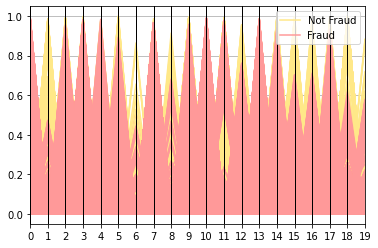

In [68]:
fig = pd.plotting.parallel_coordinates(whole,'fraud' , color=('#FFE888', '#FF9999'))
plt.savefig('img/lda_dimensions')

In [69]:
ave.index

Int64Index([0, 1], dtype='int64', name='fraud')

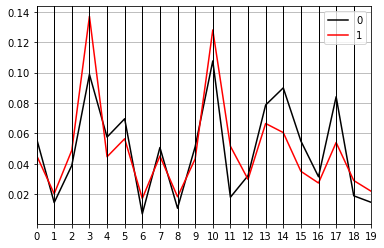

In [70]:
fig = pd.plotting.parallel_coordinates(ave, 'fraud' ,color=('black', 'red'))
plt.savefig('img/mean_lda')

In [72]:
sm = SMOTE()

In [73]:
X_train, y_train = sm.fit_sample(X_train,y_train.ravel())

In [74]:
lda_forest = RandomForestClassifier()

In [75]:
lda_forest.fit(X_train, y_train)

RandomForestClassifier()

In [76]:
cross_val_score(lda_forest,X_train,y_train, cv=10).mean()

0.9241494535373518

In [77]:
# Recall Score
preds = lda_forest.predict(X_test)
print(recall_score(y_test, preds))

0.4953560371517028


In [78]:
# #ridSearch to try out different params

# estimators = np.arange(100, 120, 1)
# num_samples_param = np.arange(5,95,10)
# parameters = {'n_estimators' : estimators}
# clf = GridSearchCV(lda_forest, parameters, cv=10, n_jobs=-1)
# clf.fit(X_train,y_train)
# print('Accuracy score: {:.3}'.format(clf.score(X_test, y_test)))

In [79]:
preds = lda_forest.predict(X_test)
recall_score(y_test,preds)

0.4953560371517028

In [80]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, preds)
#matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
matrix

array([[2924,  338],
       [ 163,  160]])

In [81]:
# # Build the plot
# plt.figure(figsize=(16,7))
# sns.set(font_scale=1.4)
# sns.heatmap(matrix, annot=True, annot_kws={'size':15},
#             cmap=plt.cm.Reds, linewidths=0.2)

# # Add labels to the plot
# class_names = ['Not Fraud', 'Fraud']
# tick_marks = np.arange(len(class_names))
# tick_marks2 = tick_marks + 0.5
# plt.xticks(tick_marks+.5, class_names, rotation=0)
# plt.yticks(tick_marks2 , class_names, rotation=0)
# plt.xlabel('PREDICTED')
# plt.ylabel('TRUE')
# plt.title('Confusion Matrix for Random Forest Model Based on LDA Vector')
# plt.savefig('img/confusion_lda2.jpg')
# plt.show()

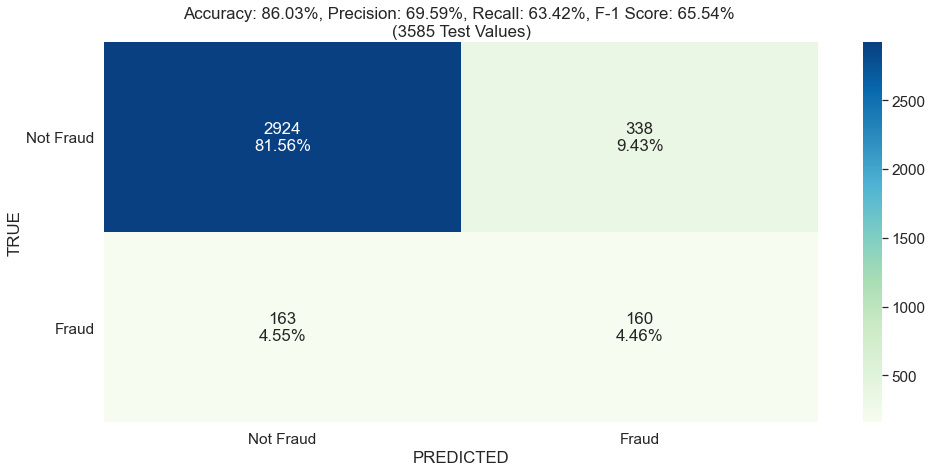

In [82]:
# Build the plot
plt.figure(figsize=(16,7))
labels = [0,1]
accuracy = accuracy_score(preds, y_test)
precision = precision_score(preds, y_test, labels=labels, average = 'macro')
recall = recall_score(preds, y_test, labels=labels, average = 'macro')
f1 = f1_score(preds, y_test, labels=labels, average = 'macro')
group_counts = ["{0:0.0f}\n".format(value) for value in matrix .flatten()]
group_percentages = ["{0:.2%}".format(value) for value in matrix .flatten()/np.sum(matrix)]

box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts,group_percentages)]
box_labels = np.asarray(box_labels).reshape(matrix .shape[0],matrix .shape[1])


sns.set(font_scale=1.4)

sns.heatmap(matrix , annot=box_labels, fmt='', cmap='GnBu',
            xticklabels=['Fraud', 'Not Fraud'],yticklabels=['Fraud', 'Not Fraud'])

# sns.heatmap(matrix, annot=True, annot_kws={'size':15},
#             cmap=plt.cm.Reds, linewidths=0.2)



# Add labels to the plot
class_names = ['Not Fraud', 'Fraud']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks+.5, class_names, rotation=0)
plt.yticks(tick_marks2 , class_names, rotation=0)
plt.xlabel('PREDICTED')
plt.ylabel('TRUE')
plt.title('Accuracy: {:.2%}, Precision: {:.2%}, Recall: {:.2%}, F-1 Score: {:.2%} \n({} Test Values)'.format(accuracy,precision, recall, f1, len(y_test)))
plt.savefig('img/confusion_lda2.jpg')
plt.show()

In [83]:
lda.get_topics()

array([[8.0167665e-05, 2.3991366e-04, 2.9880517e-05, ..., 4.5281425e-07,
        4.5281425e-07, 4.5281115e-07],
       [1.0328137e-04, 3.1838473e-03, 3.0030066e-04, ..., 2.8162913e-06,
        2.8162913e-06, 2.8162913e-06],
       [6.8807061e-04, 1.9064096e-03, 2.7749993e-04, ..., 8.0507220e-07,
        8.0507220e-07, 8.0507243e-07],
       ...,
       [2.4367368e-04, 4.9764531e-05, 4.6013392e-05, ..., 3.1881987e-07,
        3.1881987e-07, 3.1881987e-07],
       [8.0921709e-05, 4.5290537e-05, 1.5861496e-04, ..., 1.0756362e-06,
        1.0756362e-06, 1.0756373e-06],
       [1.7110852e-04, 1.6184300e-02, 3.6622139e-05, ..., 2.4004130e-06,
        2.4004130e-06, 2.4004130e-06]], dtype=float32)

In [84]:
lda.show_topic(0)

[('new', 0.008268269),
 ('commun', 0.0063485387),
 ('event', 0.0061623105),
 ('social', 0.0061280676),
 ('get', 0.0058599096),
 ('busi', 0.0054829326),
 ('make', 0.0052011963),
 ('help', 0.004864469),
 ('peopl', 0.0048591495),
 ('startup', 0.0047900295)]

In [85]:
#perplexity score (how good the model is, lower is better )
lda.log_perplexity(common_corpus)

-9.65753131917649

In [86]:
coherence_model_lda = CoherenceModel(model=lda, texts=common_corpus, dictionary=common_dictionary, coherence='c_v')

In [87]:
#coherence_score
coherence_lda = coherence_model_lda.get_coherence()
coherence_lda

/Users/hyorimlee/opt/anaconda3/lib/python3.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:202: RuntimeWarning: invalid value encountered in true_divide
  numerator = (co_occur_count / num_docs) + EPSILON
/Users/hyorimlee/opt/anaconda3/lib/python3.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:203: RuntimeWarning: invalid value encountered in true_divide
  denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
/Users/hyorimlee/opt/anaconda3/lib/python3.7/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:198: RuntimeWarning: invalid value encountered in true_divide
  co_doc_prob = co_occur_count / num_docs


nan

In [89]:
ave = lda_vector.groupby('fraud').mean()
ave

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
fraud,,,,,,,,,,,,,,,,,,,,
0,0.056612,0.014399,0.038889,0.098803,0.057531,0.069580,0.006949,0.050650,0.010707,0.051206,0.107655,0.017931,0.032145,0.078647,0.089913,0.054937,0.031408,0.084072,0.018864,0.014527
1,0.045519,0.020204,0.048862,0.137073,0.044574,0.056436,0.017085,0.045045,0.018241,0.043152,0.128049,0.051504,0.029701,0.066463,0.060502,0.034987,0.027298,0.053945,0.028932,0.021766


In [90]:
ave['fraud'] = [0,1]

In [91]:
ave

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,fraud
fraud,,,,,,,,,,,,,,,,,,,,,
0,0.056612,0.014399,0.038889,0.098803,0.057531,0.069580,0.006949,0.050650,0.010707,0.051206,...,0.017931,0.032145,0.078647,0.089913,0.054937,0.031408,0.084072,0.018864,0.014527,0
1,0.045519,0.020204,0.048862,0.137073,0.044574,0.056436,0.017085,0.045045,0.018241,0.043152,...,0.051504,0.029701,0.066463,0.060502,0.034987,0.027298,0.053945,0.028932,0.021766,1


# LSI Model

In [92]:
lsi = gensim.models.LsiModel(common_corpus, id2word=common_dictionary, num_topics=20)

In [93]:
lsi.print_topics()

[(0,
  '0.233*"event" + 0.183*"busi" + 0.172*"ticket" + 0.141*"time" + 0.137*"com" + 0.134*"new" + 0.133*"work" + 0.133*"one" + 0.127*"includ" + 0.123*"year"'),
 (1,
  '0.759*"de" + 0.333*"le" + 0.255*"et" + 0.254*"la" + 0.201*"à" + 0.160*"en" + 0.120*"du" + 0.113*"pour" + 0.101*"un" + 0.090*"vou"'),
 (2,
  '-0.489*"ticket" + 0.290*"busi" + -0.235*"event" + -0.170*"com" + 0.156*"manag" + -0.140*"ride" + 0.139*"develop" + 0.133*"market" + 0.129*"work" + -0.122*"parti"'),
 (3,
  '-0.462*"com" + -0.337*"www" + 0.285*"ride" + -0.193*"http" + 0.171*"hors" + -0.170*"new" + -0.165*"facebook" + 0.136*"time" + 0.126*"beach" + -0.122*"music"'),
 (4,
  '0.545*"busi" + 0.333*"event" + 0.259*"ticket" + -0.192*"class" + 0.178*"network" + -0.174*"cours" + -0.171*"com" + 0.169*"market" + -0.129*"www" + 0.102*"start"'),
 (5,
  '0.424*"ride" + -0.285*"event" + 0.259*"hors" + 0.202*"busi" + 0.199*"beach" + -0.180*"ticket" + 0.173*"com" + 0.157*"time" + 0.123*"www" + 0.120*"rider"'),
 (6,
  '-0.304*"com" 

In [94]:
topic_vectors = []
for i in range(len(common_corpus)):
    topic_vectors.append(lsi[common_corpus[i]])

In [95]:
df_vector = pd.DataFrame(zero_data, columns=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19'])

In [96]:
for i in range(len(common_corpus)):
    for j in range(len(topic_vectors[i])):
        df_vector.iloc[i][str(topic_vectors[i][j][0])] = topic_vectors[i][j][1]

In [97]:
lsi_vector = df_vector

In [98]:
lsi_vector['fraud'] = df.acct_type

In [99]:
lsi_vector

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,fraud
0,3.621600,-0.141238,-3.345678,-1.651133,-0.383689,0.512175,1.576811,1.035093,0.285932,-1.918013,...,-0.501673,-0.015444,1.014300,1.211424,0.443429,2.195993,-0.001727,4.310697,-0.324981,1
1,5.780769,-0.464254,-1.644415,1.203552,-0.644938,-1.976511,1.039346,-0.099617,-1.448731,-0.863087,...,-2.420367,-1.038485,0.097151,0.043525,-0.618685,-0.292637,0.134824,0.529547,-0.016767,0
2,4.723428,-0.446696,-0.010508,2.548243,-0.972565,-1.909409,-2.166241,-1.477415,-0.339083,-0.684484,...,-1.222850,-0.212309,0.674830,0.865073,0.051525,1.233910,-0.259763,-0.751701,-0.106015,0
3,11.256209,-0.296095,3.213545,-0.167995,-1.870157,-3.198295,0.937469,-5.948642,-2.693087,-3.516629,...,-1.280997,1.595520,-0.281242,2.021806,-0.234451,0.795050,-3.467675,-0.332934,2.241913,0
4,4.893311,-0.327756,1.809838,-0.755366,0.755035,0.892941,0.845317,0.454252,1.635841,-1.194835,...,-0.417872,-1.735021,-0.843372,-0.013163,0.388332,0.075299,-0.048810,-1.496276,-2.204891,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14332,1.729116,-0.113408,-1.152548,-0.440340,0.268726,-0.473591,0.947675,1.029696,-0.976507,-0.734515,...,0.327566,-0.043208,0.289201,0.040124,-0.280735,0.485710,0.136598,0.501084,0.253828,1
14333,4.799743,0.265634,0.148100,-0.972965,-0.507895,-1.342577,2.112359,-1.664393,-1.286884,-0.901503,...,0.596213,-0.016159,-0.133786,-0.881976,-1.214061,-0.334957,0.590439,-1.425255,0.068220,0
14334,1.429713,-0.162306,-0.360474,0.048668,-0.300720,0.352388,0.343266,1.018087,0.029932,0.024517,...,-0.163705,0.389655,0.095067,-0.029851,-0.364420,-0.274249,0.033985,-0.170099,0.264322,0
14335,5.333854,5.679179,-3.962124,0.039195,0.470724,-1.337946,1.503730,1.379893,1.156166,-0.349291,...,0.270740,-0.471031,-0.251691,0.364415,-0.191076,1.563455,0.422490,0.757046,-0.052466,0


In [100]:
#lsi_vector.drop(columns=['fraud']).to_csv('data/lsi_vector.csv')

## LSI_RandomForest

In [101]:
# Since it's imbalanced data, resample fraud == 1 

In [102]:
X = lsi_vector.drop(columns=['fraud'])
y = lsi_vector.fraud

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, shuffle=True, random_state=4)

In [104]:
sm = SMOTE()
X_train,y_train = sm.fit_resample(X_train, y_train)

In [105]:
whole = pd.concat([X_train, y_train], axis=1)

In [106]:
whole.fraud = whole.fraud.astype('str')

In [107]:
whole.fraud[whole.fraud == '1'] = 'Fraud'

/Users/hyorimlee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [108]:
whole.fraud[whole.fraud == '0'] = 'Not Fraud'

/Users/hyorimlee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


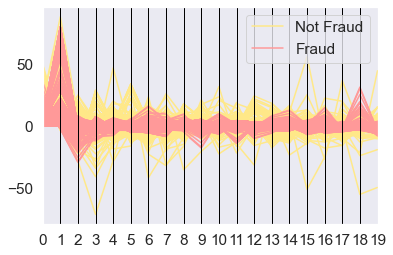

In [109]:
fig = pd.plotting.parallel_coordinates(whole,'fraud' , color=('#FFE888', '#FF9999'))
plt.savefig('img/lsi_dimensions2')

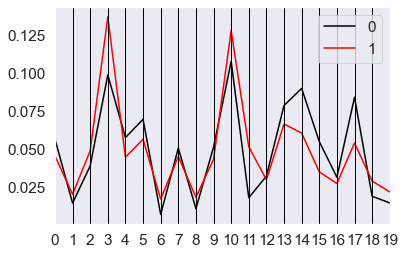

In [110]:
fig = pd.plotting.parallel_coordinates(ave, 'fraud' ,color=('black', 'red'))
plt.savefig('img/mean_lsi')

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, shuffle=True, random_state=4)

In [112]:
sm = SMOTE()


In [113]:
X_train, y_train = sm.fit_sample(X_train,y_train.ravel())

In [114]:
lsi_forest = RandomForestClassifier()

In [115]:
lsi_forest.fit(X_train, y_train)
trained_model = lsi_forest.fit(X_train, y_train.ravel())

In [116]:
cross_val_score(lsi_forest,X_train,y_train, cv=10).mean()

0.9296152033547445

In [117]:
# Recall Score
preds = lsi_forest.predict(X_test)
print(recall_score(y_test, preds))

0.544891640866873


In [118]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, preds)
#matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
matrix

array([[2923,  339],
       [ 147,  176]])

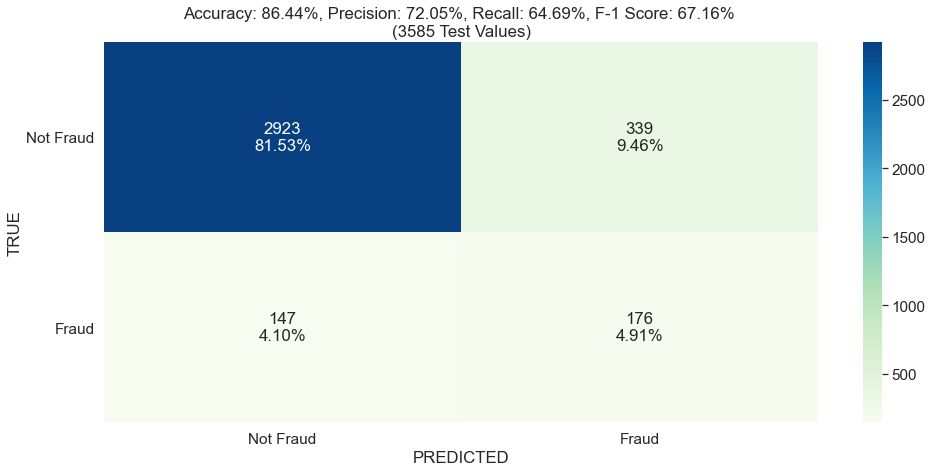

In [119]:
# Build the plot
plt.figure(figsize=(16,7))

accuracy = accuracy_score(preds, y_test)
precision = precision_score(preds, y_test, labels=labels, average = 'macro')
recall = recall_score(preds, y_test, labels=labels, average = 'macro')
f1 = f1_score(preds, y_test, labels=labels, average = 'macro')
group_counts = ["{0:0.0f}\n".format(value) for value in matrix .flatten()]
group_percentages = ["{0:.2%}".format(value) for value in matrix .flatten()/np.sum(matrix)]

box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts,group_percentages)]
box_labels = np.asarray(box_labels).reshape(matrix .shape[0],matrix .shape[1])


sns.set(font_scale=1.4)

sns.heatmap(matrix , annot=box_labels, fmt='', cmap='GnBu',
            xticklabels=['Fraud', 'Not Fraud'],yticklabels=['Fraud', 'Not Fraud'])

# sns.heatmap(matrix, annot=True, annot_kws={'size':15},
#             cmap=plt.cm.Reds, linewidths=0.2)



# Add labels to the plot
class_names = ['Not Fraud', 'Fraud']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks+.5, class_names, rotation=0)
plt.yticks(tick_marks2 , class_names, rotation=0)
plt.xlabel('PREDICTED')
plt.ylabel('TRUE')
plt.title('Accuracy: {:.2%}, Precision: {:.2%}, Recall: {:.2%}, F-1 Score: {:.2%} \n({} Test Values)'.format(accuracy,precision, recall, f1, len(y_test)))
plt.savefig('img/confusion_lsi2.jpg')
plt.show()

In [121]:
# y_pred_sample_score = trained_model.decision_function(X_test)
# y_test_bin = []
# for i in y_test:
#     if i==1:
#         y_test_bin.append(0)
#     else:
#         y_test_bin.append(1)
        
# fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_sample_score)
# roc_auc = auc(fpr,tpr)
# # Plot ROC
# plt.figure(figsize = (12, 8)) #figsize = (24, 16)
# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
# plt.legend(loc='lower right')
# plt.plot([0,1],[0,1],'r--')
# plt.xlim([-0.1,1.0])
# plt.ylim([-0.1,1.01])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

In [ ]:
# #GridSearch to try out different params

# estimators = np.arange(100, 120, 1)
# num_samples_param = np.arange(5,95,10)
# parameters = {'n_estimators' : estimators}
# clf = GridSearchCV(lsi_forest, parameters, cv=10, n_jobs=-1)
# clf.fit(X_train,y_train)
# print('Accuracy score: {:.3}'.format(clf.score(X_test, y_test)))

In [ ]:
# preds = clf.predict(X_test)

In [ ]:
# recall_score(y_test,preds)